In [19]:
import os
import pandas as pd
import numpy as np
import math
import seaborn as sns
from graphing_functions import *
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib import ticker
from matplotlib.lines import Line2D

### File Inputs

In [20]:
# Choose between 'mtDNA' and 'TFAM'
keyword = "TFAM"

# for aggtype, choose between "mean" and "median".
# NOTE: Cell ROIs are always aggregated by median due to skewed distributions \
# This only changes how centrality is calculated for biological replicates
aggtype = "mean"

# for p-eval, choose between "roi", "cell", and "rep"
p_eval = "rep"
plot_rois = False
legend = False

In [21]:
table = pd.read_csv(f"/Volumes/Shares/SFU/Xiutang/Xiutang-Alex experiments/Project-mtDNA and aging/Aim 2/Aim 2.2/Aim 2.2-1 Quant DRG Punct/results/updated analysis/240222_analysis/{keyword}/roi_data.csv")
outputpath = "/Volumes/Shares/SFU/Xiutang/Xiutang-Alex experiments/Project-mtDNA and aging/Aim 2/Aim 2.2/Aim 2.2-1 Quant DRG Punct/results/updated analysis/240222_analysis/joint_phase"
# table = pd.read_csv(f"Z://SFU/Xiutang/Xiutang-Alex experiments/Project-mtDNA and aging/Aim 2/Aim 2.2/Aim 2.2-1 Quant DRG Punct/results/updated analysis/240222_analysis/{keyword}/roi_data.csv")
# outputpath = "Z://SFU/Xiutang/Xiutang-Alex experiments/Project-mtDNA and aging/Aim 2/Aim 2.2/Aim 2.2-1 Quant DRG Punct/results/updated analysis/240222_analysis/joint_phase"
table.head()

,Source,RoiType,Area,Mean,Min,Max,Circ.,IntDen,Median,RawIntDen,AR,Round,Solidity
0,230210_TFAM_aged_i16,punctate,0.479,4.540,0,15,0.494,2.174,3,1607.0,3.560,0.281,0.810
1,230210_TFAM_aged_i16,punctate,0.049,1.667,0,4,0.998,0.081,2,60.0,1.332,0.751,0.878
2,230210_TFAM_aged_i16,punctate,0.099,0.000,0,0,0.827,0.000,0,0.0,1.115,0.897,0.869
3,230210_TFAM_aged_i16,punctate,0.145,6.991,1,14,0.918,1.012,6,748.0,1.734,0.577,0.918
4,230210_TFAM_aged_i16,punctate,0.199,0.075,0,2,0.780,0.015,0,11.0,2.153,0.465,0.878


In [22]:
table_edits = table
table_edits['Group'] = table['Source'].str.split("_").str[2]
table_edits['Date'] = table['Source'].str.split('_').str[0]
print(f"Table shape {table_edits.shape}")
table_edits.head()

Table shape (16401, 15)


,Source,RoiType,Area,Mean,Min,Max,Circ.,IntDen,Median,RawIntDen,AR,Round,Solidity,Group,Date
0,230210_TFAM_aged_i16,punctate,0.479,4.540,0,15,0.494,2.174,3,1607.0,3.560,0.281,0.810,aged,230210
1,230210_TFAM_aged_i16,punctate,0.049,1.667,0,4,0.998,0.081,2,60.0,1.332,0.751,0.878,aged,230210
2,230210_TFAM_aged_i16,punctate,0.099,0.000,0,0,0.827,0.000,0,0.0,1.115,0.897,0.869,aged,230210
3,230210_TFAM_aged_i16,punctate,0.145,6.991,1,14,0.918,1.012,6,748.0,1.734,0.577,0.918,aged,230210
4,230210_TFAM_aged_i16,punctate,0.199,0.075,0,2,0.780,0.015,0,11.0,2.153,0.465,0.878,aged,230210


### Removal of Outliers

1. Removal of cells with visually defective AI predictions from the dataset

In [23]:
poor_predictions = {
    # 64 mtDNA images - 5 = 59 images left
    'mtDNA': ['221207_mtDNA_young_i3', '230727_mtDNA_young_i3', 
              '230731_mtDNA_aged_i14l', '230731_mtDNA_aged_14u', 
              '230731_mtDNA_aged_i18'],
    # 30 TFAM images - 2 images = 28 images left
    'TFAM': ['230210_TFAM_aged_i26', '230210_TFAM_aged_i25']
}

before_count = table_edits.shape[0]
print(f"{before_count} rois before cell removal")
for cell in poor_predictions[keyword]:
    table_edits = table_edits[table_edits['Source'] != cell]
print(f"{table_edits.shape[0]} rois after removal")
print(f"{before_count - table_edits.shape[0]} rois removed")

16401 rois before cell removal
15249 rois after removal
1152 rois removed


2. Removal of outliers via 1.5 IQR

Checking distribution of punctate ROI area prior to outlier removal

<Axes: xlabel='Area', ylabel='Density'>

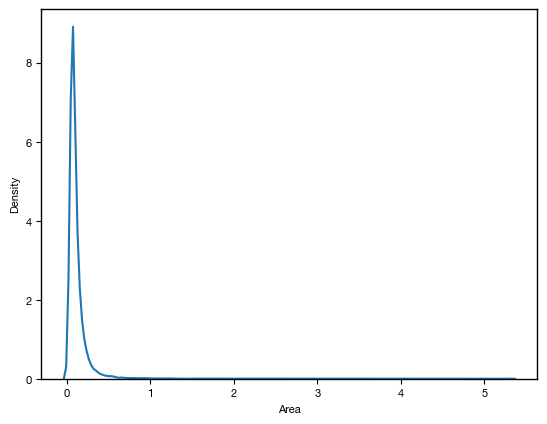

In [24]:
sns.kdeplot(data=table_edits['Area'])

In [25]:
#2.2 - removal of rois for each dataset using z-score
no_outlier = iqr_removal(table_edits)
na = no_outlier.isna().sum()

summary = pd.concat([na, round(na / table_edits.shape[0] * 100)], axis = 1)
summary.columns = ['outlier#', 'outlier%']
summary

,outlier#,outlier%
Source,0,0.0
RoiType,0,0.0
Area,1943,13.0
Mean,2193,14.0
Min,655,4.0
Max,1338,9.0
Circ.,1262,8.0
IntDen,2080,14.0
Median,2240,15.0
RawIntDen,2039,13.0


Checking distribution for punctate ROI after outlier removal

<Axes: xlabel='Area', ylabel='Density'>

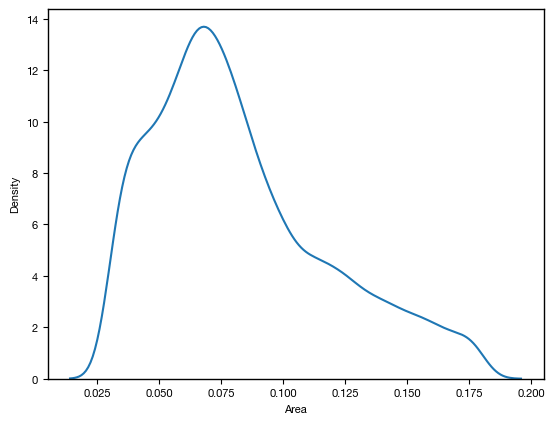

In [26]:
sns.kdeplot(data=no_outlier['Area'])

In [27]:
# no_outlier = no_outlier[["Source", "Date", "Group", "RoiType", "Area", "Mean", "Min", "Max",
#                             "Circ.", "IntDen", "Median", "RawIntDen", "AR", "Round", "Solidity"]].dropna()
no_outlier = no_outlier[["Source", "Date", "Group", "RoiType", "Area", "Mean", "Circ."]].dropna()

In [28]:
print(no_outlier.shape)
no_outlier.to_csv(os.path.join(outputpath, f"{keyword}_ROIs_jointPhase_noOutlier.csv"))

(11015, 7)


### Grouping and Aggregating Data

First at the level of an individual cell

In [29]:
cell_dict = {}
for header in no_outlier.columns:
    if header == "Source" or header == "RoiType" or header == "Group":
        continue
    elif header == "Date":
        cell_dict[header] = "first"
    else:
        cell_dict[header] = aggtype

cell_means = no_outlier.groupby(["Source","Group"]).agg(cell_dict)
cell_means = cell_means.reset_index()
cell_means.head()

,Source,Group,Date,Area,Mean,Circ.
0,230210_TFAM_aged_i16,aged,230210,0.087848,36.053921,0.842067
1,230210_TFAM_aged_i18,aged,230210,0.091703,36.934636,0.800483
2,230210_TFAM_aged_i22,aged,230210,0.093146,56.339603,0.835819
3,230210_TFAM_aged_i23,aged,230210,0.076935,50.263991,0.792608
4,230217_TFAM_aged_i25,aged,230217,0.076531,63.884397,0.824647


In [30]:
print(cell_means.shape)
cell_means.to_csv(os.path.join(outputpath, f"{keyword}_jointPhase_cellMeans.csv"))

(27, 6)


Then at the level of a biological replicate

In [31]:
rep_dict = {}
# for header in no_outlier.columns:
for header in cell_means.columns:
    if header == "Date" or header == "RoiType" or header == "Group":
        continue
    elif header == "Source":
        rep_dict[header] = "first"
    else:
        rep_dict[header] = aggtype

rep_means = cell_means.groupby(["Date","Group"]).agg(rep_dict)
rep_means = rep_means.reset_index()
rep_means.head()

,Date,Group,Source,Area,Mean,Circ.
0,230210,aged,230210_TFAM_aged_i16,0.087408,44.898038,0.817744
1,230217,aged,230217_TFAM_aged_i25,0.076727,59.648476,0.833151
2,230224,young,230224_TFAM_young_i15,0.075306,70.513369,0.870899
3,230726,young,230726_TFAM_young_i1,0.077922,61.454153,0.865575
4,230727,young,230727_TFAM_young_i11,0.077190,68.771532,0.865683


In [32]:
print(rep_means.shape)
rep_means.to_csv(os.path.join(outputpath, f"{keyword}_jointPhase_repMeans.csv"))

(6, 6)


### Computing p-values to be graphed

In [33]:
rep_pvalues = {}
if p_eval == 'roi':
   pdict = no_outlier
elif p_eval == 'cell':
   pdict = cell_means
elif p_eval == 'rep':
   pdict = rep_means
else:
   raise ValueError(f"p_eval value '{p_eval}' not recognized. Please choose between 'roi', 'cell', and 'rep'")

print(rep_dict.items())
for key, value in rep_dict.items():
    if value == "first":
       continue 
    pYoung = pdict[pdict["Group"] == 'young'][key]
    pAged = pdict[pdict["Group"] == 'aged'][key]
    pP = stats.mannwhitneyu(pYoung, pAged)[1]

    pP = round(pP, 10)
    rep_pvalues[key] = pP

dict_items([('Source', 'first'), ('Area', 'mean'), ('Mean', 'mean'), ('Circ.', 'mean')])


In [34]:
rep_pvalues

{'Area': 0.4, 'Mean': 0.1, 'Circ.': 0.1}

### Plotting data and saving plots to output directory

In [35]:
def plot_y(pDict, yMetric, outpath, log=False):    
    hue_order = sorted(table_edits['Date'].unique()[::-1])
    fig = plt.figure(figsize=(1.5,2))

    ax1 = fig.add_subplot(1, 1, 1)

    gOrder = ["young", "aged"]

    maxtable = cell_means if not plot_rois else no_outlier
    tempymin = maxtable[yMetric].min()
    tempymax = maxtable[yMetric].max()

    # Plotting points...
    if plot_rois:
        sns.stripplot(data=no_outlier, x="Group", y=yMetric, order=gOrder, hue="Date", hue_order=hue_order, jitter=0.3, alpha=0.33, size=0.5, ax=ax1, legend=False, zorder=0)

    sns.swarmplot(data=cell_means, x="Group", y=yMetric, order=gOrder, hue="Date", hue_order=hue_order, size=1, linewidth=0.3, ax=ax1, legend=False, zorder=1)

    plot_sem(ax1, 0, 0.15, cell_means, yMetric, 'young')
    plot_sem(ax1, 1, 0.15, cell_means, yMetric, 'aged')

    sns.swarmplot(data=rep_means, x="Group", y=yMetric, order=gOrder, hue="Date", hue_order=hue_order, size=2.5, linewidth=0.55, ax=ax1, legend=False, zorder=2)

    # Y-Axis formatting
    if tempymax < 1:
        ymax = tempymax * 1.1
    elif tempymax > 1:
        ymax = tempymax * 1.1
    else:
        ymax = 1.1
    ax1.set_ylim((tempymin / 1.2, ymax))
    ax1.yaxis.set_tick_params(width=0.5, pad=0.35)
    ax1.xaxis.set_tick_params(width=0.5, pad=0.5)

    # X-Axis formatting
    ax1.set_xlim(left=-0.5, right=1.5)
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(["P30\ndays", "P24\nmonths"])

    # Axis labels
    ax1.set_ylabel(process_title(yMetric, keyword))
    ax1.set_xlabel("")
    ax1.set_title("")

    # Legend formatting
    if legend:
        markers = [Line2D(range(1), range(1), linewidth=0, marker='o', markersize=1, markerfacecolor='#e4e4e4', markeredgecolor="gray"),
                Line2D(range(1), range(1), linewidth=0, marker='o', markersize=2, markerfacecolor='#e4e4e4', markeredgecolor="gray"),]
        marker_labels = ["Single Cell All-ROI Mean", 
                        "Single Rep All-ROI Mean"]
        markers.insert(0, Line2D(range(1), range(1), linewidth=0, marker='o', markersize=1, markerfacecolor='#e4e4e4', markeredgecolor="gray")) if plot_rois else '' 
        marker_labels.insert(0, "Individual ROI") if plot_rois else ''
        lgnd = ax1.legend(markers, marker_labels) 
        sns.move_legend(ax1, "lower center", bbox_to_anchor = (0.5, -0.29))

    # Graphing p-values
    ymax2 = tempymax * 1.05
    ax1.plot([0, 1], [ymax2, ymax2], c = 'k', linewidth = 0.5)
    pP = pDict[yMetric]
    ax1.text(0.5, ymax2, f"{format_p(pP)}", ha="center", va="bottom", c='k', weight = 'bold')

    # Final Figure Formatting
    ax1.spines[['right', 'top']].set_visible(False)

    plt.subplots_adjust(wspace=0.05)
    plt.tight_layout()
    plt.savefig(os.path.join(outpath, f"{keyword}_{'all' if plot_rois else ''}GroupedROI-{yMetric}_{aggtype}Agg_{p_eval}Stat.png"), dpi=1800)
    plt.close()

In [36]:
# plt.style.use("ggplot")
# plt.rcParams['axes.facecolor']='#e4e4e4'
plt.rc('font', family="Helvetica Neue", size=8)
plt.rcParams['axes.linewidth'] = 1

for key, value in rep_dict.items():
   if value == "first":
       continue 
   #this_log = True if key in ["Area", "Median", "Min", "Solidity", "IntDen"] else False
   plot_y(rep_pvalues, key, outputpath, log=True)